# Static Plots

- [pandas.DataFrame.plot — pandas 1.4.1 documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)
- [Matplotlib — Visualization with Python](https://matplotlib.org/)
- [seaborn: statistical data visualization — seaborn 0.11.2 documentation](https://seaborn.pydata.org/)
- [Chart Visualization — pandas 1.4.2 documentation](https://pandas.pydata.org/docs/user_guide/visualization.html)



## 目次
- 約定データ取得
- df.plot() を使い倒す（倒したい）
- 探索的データ分析(EDA)


## 約定データ
- [crypto-chassis/cryptochassis-data-api-docs: A REST API providing snapshot, tick, and aggregated market data for crypto-currencies](https://github.com/crypto-chassis/cryptochassis-data-api-docs#trade)


In [1]:
import pandas as pd

In [2]:
df_eth_eur =pd.read_pickle("../data/binance_btc-eur.pkl")
df_btc_eur =pd.read_pickle("../data/binance_eth-eur.pkl")



In [3]:
df_btc_eur.head()

,time_seconds,price,size,is_buyer_maker,instrument
datetime,,,,,
2022-03-23 00:00:03.676999936+00:00,1.647994e+09,2694.72,0.2356,1,eth-eur
2022-03-23 00:00:03.691000064+00:00,1.647994e+09,2694.72,0.6909,1,eth-eur
2022-03-23 00:00:03.701999872+00:00,1.647994e+09,2694.72,0.2317,1,eth-eur
2022-03-23 00:00:03.755000064+00:00,1.647994e+09,2694.72,0.1260,1,eth-eur
2022-03-23 00:00:03.851000064+00:00,1.647994e+09,2694.73,0.0630,1,eth-eur


In [4]:
df_btc_eur.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1311089 entries, 2022-03-23 00:00:03.676999936+00:00 to 2022-03-06 23:59:43.257999872+00:00
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   time_seconds    1311089 non-null  float64
 1   price           1311089 non-null  float64
 2   size            1311089 non-null  float64
 3   is_buyer_maker  1311089 non-null  int64  
 4   instrument      1311089 non-null  object 
dtypes: float64(3), int64(1), object(1)
memory usage: 60.0+ MB


In [5]:
# 5分のOHLCVに変換
rule="15min"
df_ohlc_btc_eur = df_btc_eur["price"].resample(rule, label="right").ohlc()
df_ohlc_btc_eur["volume"] = df_btc_eur["size"].resample(rule, label="right").sum()

df_ohlc_eth_eur = df_eth_eur["price"].resample(rule, label="right").ohlc()
df_ohlc_eth_eur["volume"] = df_eth_eur["size"].resample(rule, label="right").sum()



In [6]:
df_ohlc_btc_eur.head()

,open,high,low,close,volume
datetime,,,,,
2022-03-01 00:15:00+00:00,2605.42,2653.14,2604.59,2639.73,829.0787
2022-03-01 00:30:00+00:00,2639.32,2641.15,2618.15,2630.50,245.6318
2022-03-01 00:45:00+00:00,2630.00,2641.00,2626.23,2632.58,218.6806
2022-03-01 01:00:00+00:00,2632.19,2639.74,2619.61,2631.00,246.4585
2022-03-01 01:15:00+00:00,2632.00,2632.88,2607.98,2609.71,182.1421


## df.plot() のオプションを使い倒す

`plot()` にはたくさんのオプションがあります。matplotlib や seaborn などを使わなくても事足りることがありますのでぜひ覚えてください。


- 価格帯別出来高
- ボリュームの(棒)グラフを下につける
- 指標は代表的なやつを1つ紹介する(SMA, RSIなど)

### plot メソッド

`plot()` はデフォルトで折れ線グラフを描画します


<AxesSubplot:xlabel='datetime'>

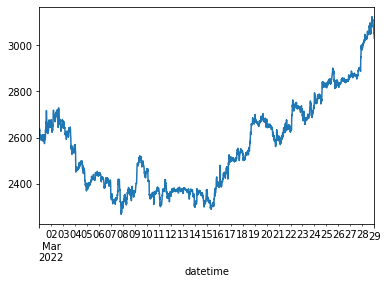

In [7]:
df_ohlc_btc_eur["close"].plot()

### plot オプション

罫線や描画サイズなど、オプションで変更できます。

<AxesSubplot:title={'center':'Close'}, xlabel='datetime'>

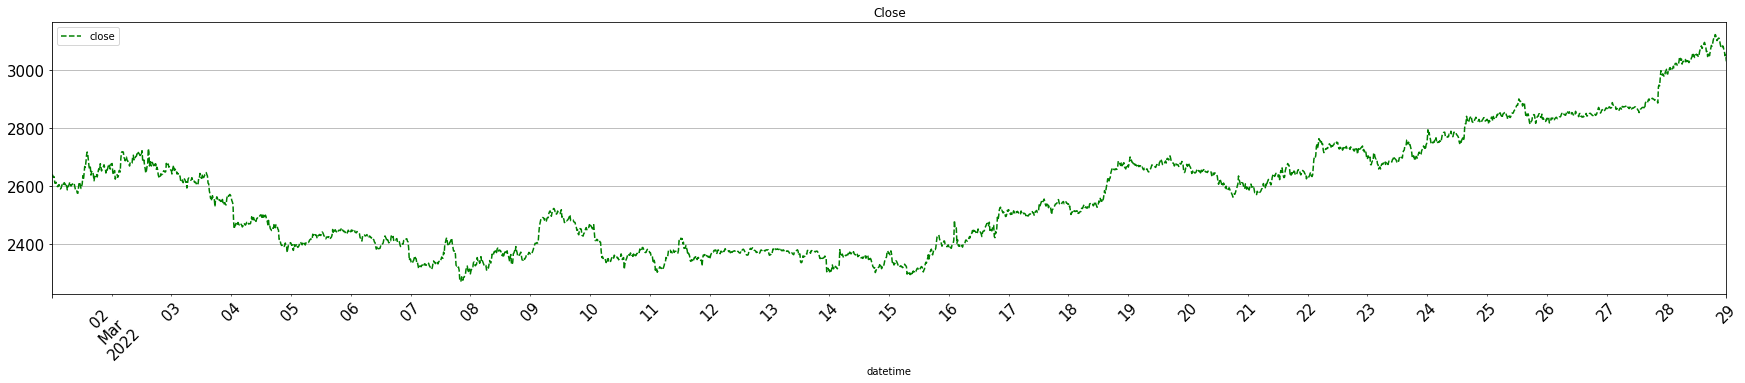

In [8]:
df_ohlc_btc_eur["close"].plot(
    grid=True, # 罫線
    figsize=(30,5),  # 描画サイズ（横、縦）
    title="Close",  # グラフタイトル
    legend=True,  # 凡例
    rot=45,  # xtick の ローテーション
    fontsize=15, # 文字サイズ
    style={"close": "g--"}, # 色と線の種類
    )

### サブプロット

同じ DataFrame にあるデータであれば、 `subplots=True,` オプションでサブプロットできます

In [9]:
import ta
df_ohlc_btc_eur["RSI14"] = ta.momentum.rsi(df_ohlc_btc_eur["close"], window=14)

ModuleNotFoundError: No module named 'ta'

In [68]:
df_ohlc_btc_eur.head()

,open,high,low,close,volume,RSI14
datetime,,,,,,
2022-03-01 00:15:00+00:00,2605.42,2653.14,2604.59,2639.73,829.0787,NaN
2022-03-01 00:30:00+00:00,2639.32,2641.15,2618.15,2630.50,245.6318,NaN
2022-03-01 00:45:00+00:00,2630.00,2641.00,2626.23,2632.58,218.6806,NaN
2022-03-01 01:00:00+00:00,2632.19,2639.74,2619.61,2631.00,246.4585,NaN
2022-03-01 01:15:00+00:00,2632.00,2632.88,2607.98,2609.71,182.1421,NaN


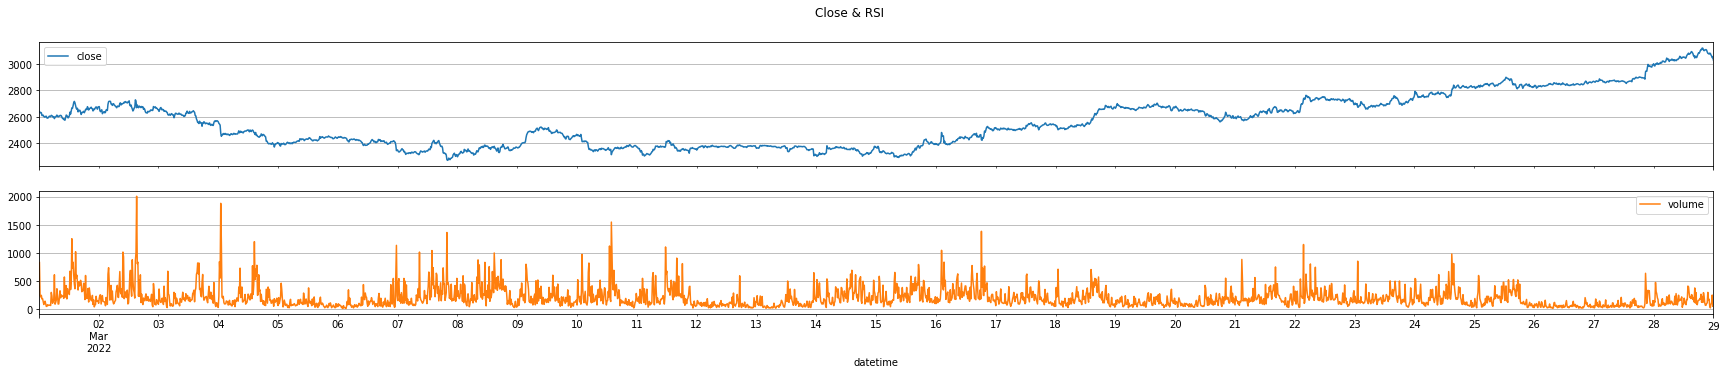

In [11]:
fig = df_ohlc_btc_eur[["close", "volume"]].plot(
    grid=True, 
    figsize=(30,5), 
    title="Close & RSI", 
    legend=True, 
    subplots=True, 
    layout=(2,1), # レイアウト（行,欄）
   
    )

In [12]:
fig

array([[<AxesSubplot:xlabel='datetime'>],
       [<AxesSubplot:xlabel='datetime'>]], dtype=object)

### 第二軸

`secondary_y=` オプションで、右側にｙの第二軸を取ることができます

<AxesSubplot:xlabel='datetime'>

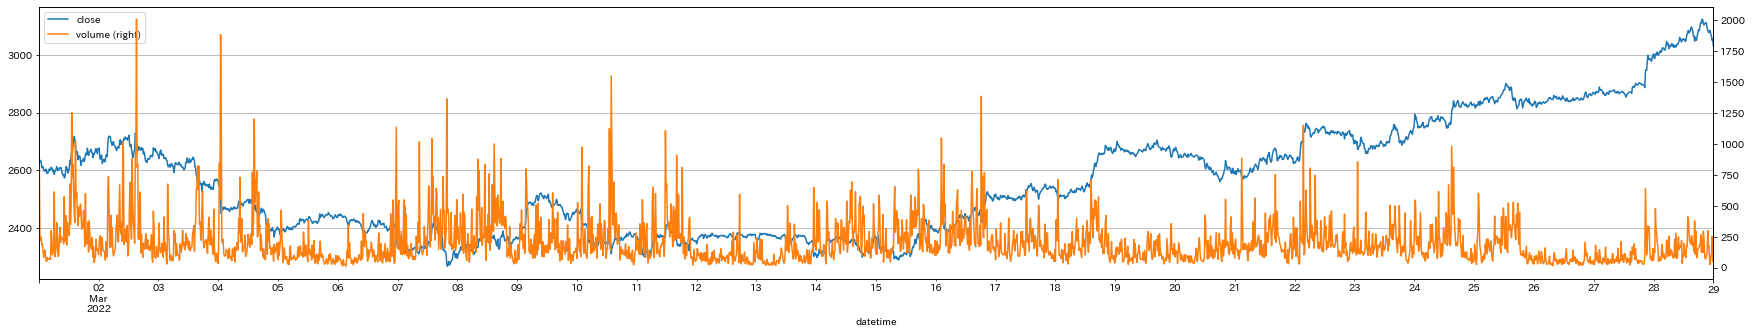

In [70]:
df_ohlc_btc_eur[["close", "volume"]].plot(
    grid=True,    
    figsize=(30,5),
    secondary_y="volume", 
    )

### bar について

TODO: 棒グラフがとても遅い。解決策をどりらんせんせいに聞く


In [ ]:
df_ohlc_btc_eur["volume"].plot(1000).plot(kind="bar", use_index = False )



### 日本語豆腐問題

<AxesSubplot:title={'center':'終値'}, xlabel='時間', ylabel='価格'>

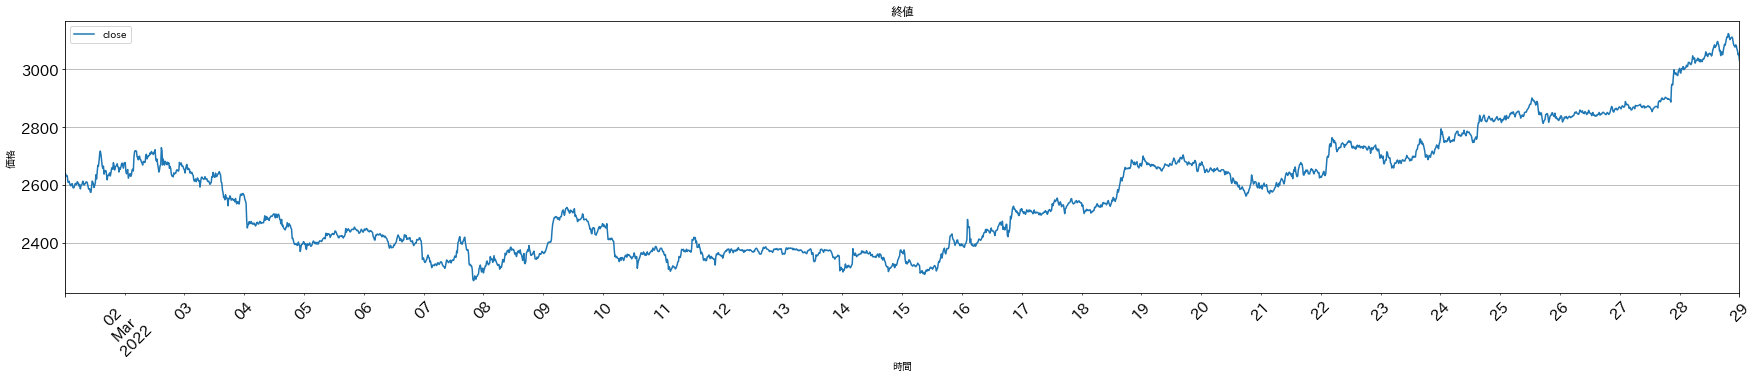

In [72]:
import japanize_matplotlib

df_ohlc_btc_eur["close"].plot(grid=True, figsize=(30,5), title="終値", legend=True, rot=45, fontsize=15, xlabel="時間", ylabel="価格")


## matplotlib も少し使う
- テストデータとして3月1日〜28日の28日分の約定データを用意している


In [81]:
df_ohlc_btc_eur["hour"] = df_ohlc_btc_eur.index.hour
df_ohlc_btc_eur["day_name"] = df_ohlc_btc_eur.index.day_name()
df_ohlc_btc_eur["price_change"] = df_ohlc_btc_eur["close"].pct_change()

<AxesSubplot:ylabel='Frequency'>

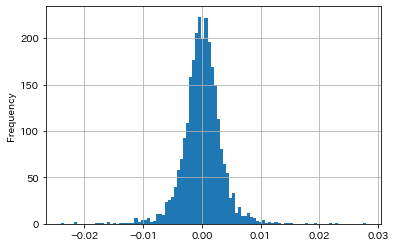

In [85]:
df_ohlc_btc_eur["price_change"].plot(kind="hist", bins=100, grid=True)

day_name
Friday       AxesSubplot(0.125,0.125;0.775x0.755)
Monday       AxesSubplot(0.125,0.125;0.775x0.755)
Saturday     AxesSubplot(0.125,0.125;0.775x0.755)
Sunday       AxesSubplot(0.125,0.125;0.775x0.755)
Thursday     AxesSubplot(0.125,0.125;0.775x0.755)
Tuesday      AxesSubplot(0.125,0.125;0.775x0.755)
Wednesday    AxesSubplot(0.125,0.125;0.775x0.755)
Name: price_change, dtype: object

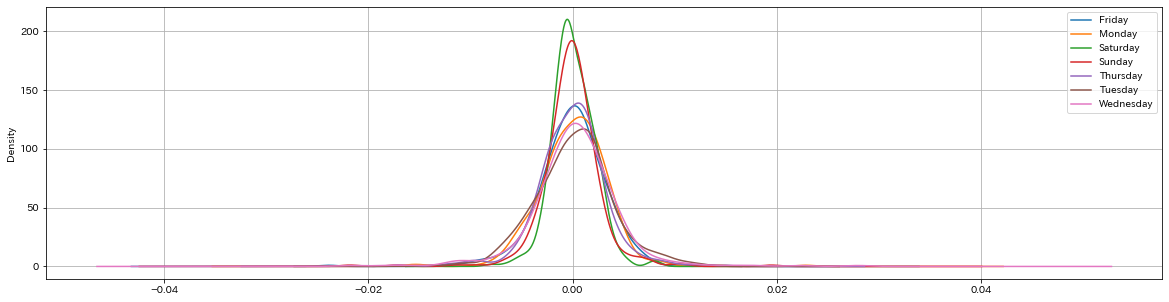

In [98]:
df_ohlc_btc_eur.groupby("day_name")["price_change"].plot(kind="kde",  grid=True, legend=True, figsize=(20,5))

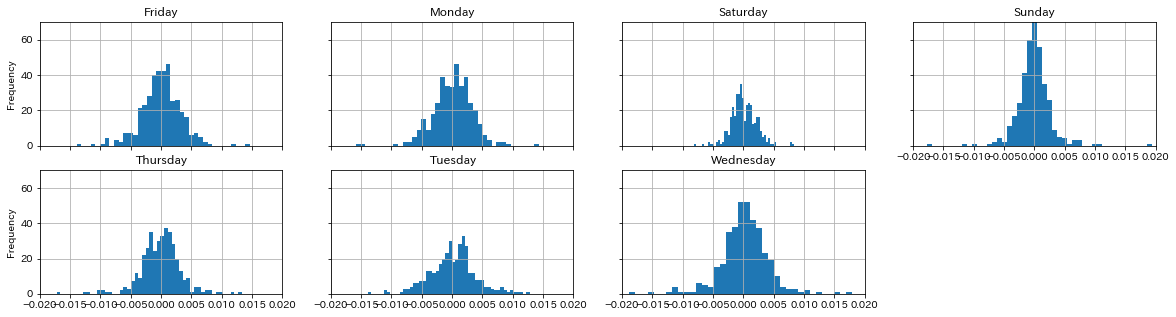

In [131]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(20,5))

i = 1
for name, s in list(df_ohlc_btc_eur.groupby("day_name")["price_change"]):
    ax = fig.add_subplot(2,4,i)
    s.plot(kind="hist", ax=ax, title=name, xlim=(-0.02, 0.02),  ylim=(0, 70), sharex=True,  sharey=True, grid=True, bins=50)
    i += 1
    

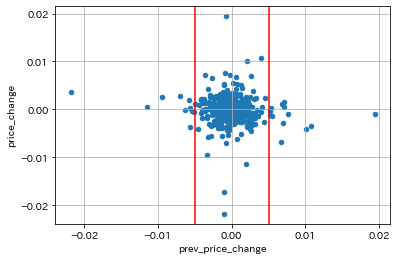

In [143]:
df_ohlc_btc_eur["prev_price_change"] = df_ohlc_btc_eur["price_change"].shift(2)
ax = df_ohlc_btc_eur[df_ohlc_btc_eur["day_name"] == "Sunday"].plot(kind="scatter", x = "prev_price_change", y="price_change", grid=True)
ax.axvline(-0.005, c="red")
ax.axvline(0.005, c="red")


matplotlibのstyleを変える - Qiita
https://qiita.com/eriksoon/items/b93030ba4dc686ecfbba

[Style sheets reference — Matplotlib 3.5.1 documentation](https://matplotlib.org/3.5.1/gallery/style_sheets/style_sheets_reference.html)




## 価格帯別出来高


In [176]:
df_15min = df_btc_eur["price"].resample("15min", label="right").ohlc()
df_15min["volume"] = df_btc_eur["size"].resample("15min", label="right").sum()
df_15min["pricecut"] = pd.cut(df_15min["close"], 30, ).apply(lambda x: x.left)
s_vol_by_price = df_15min.groupby("pricecut")["volume"].sum()

<AxesSubplot:ylabel='pricecut'>

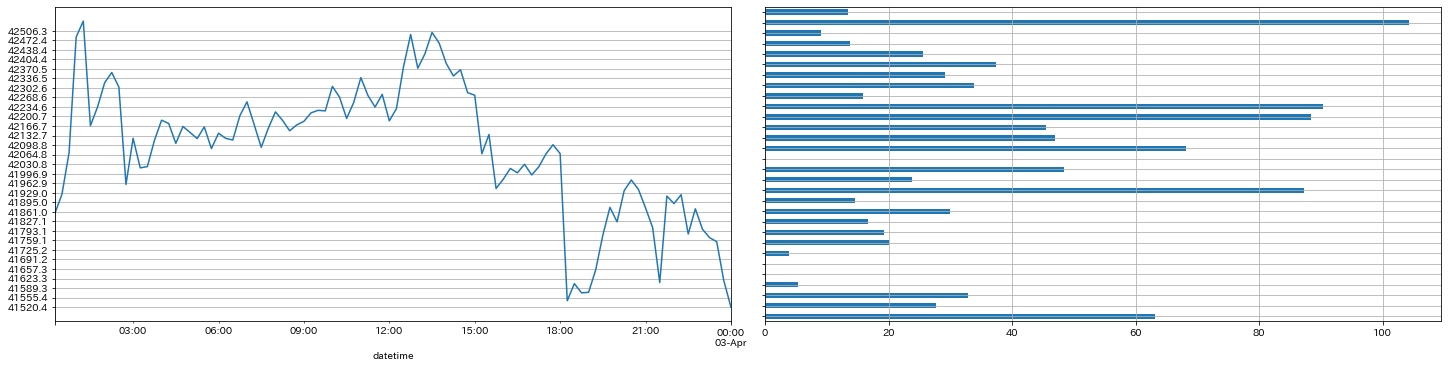

In [177]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(20, 5), constrained_layout = True)
df_15min["close"].plot(ax=axes[0], yticks=s_vol_by_price.index, grid=True)
s_vol_by_price.plot(kind="barh",ax=axes[1],sharey=axes[0], grid=True)
